[start 1/50] ||res||_2=0.457586 status=3
[start 2/50] ||res||_2=0.372254 status=3
[start 3/50] ||res||_2=0.355708 status=3
[start 4/50] ||res||_2=0.380315 status=3
[start 5/50] ||res||_2=0.470882 status=3
[start 6/50] ||res||_2=0.472825 status=3
[start 7/50] ||res||_2=0.37617 status=3
[start 8/50] ||res||_2=0.374837 status=3
[start 9/50] ||res||_2=0.346932 status=3
[start 10/50] ||res||_2=0.346608 status=2
[start 11/50] ||res||_2=0.625683 status=3
[start 12/50] ||res||_2=0.343812 status=3
[start 13/50] ||res||_2=0.44138 status=3
[start 14/50] ||res||_2=0.372893 status=3
[start 15/50] ||res||_2=0.362381 status=3
[start 16/50] ||res||_2=0.478449 status=3
[start 17/50] ||res||_2=0.442023 status=3
[start 18/50] ||res||_2=0.461476 status=3
[start 19/50] ||res||_2=0.381781 status=3
[start 20/50] ||res||_2=0.481741 status=3
[start 21/50] ||res||_2=0.434252 status=3
[start 22/50] ||res||_2=0.359677 status=3
[start 23/50] ||res||_2=0.357794 status=3
[start 24/50] ||res||_2=0.347809 status=3
[st

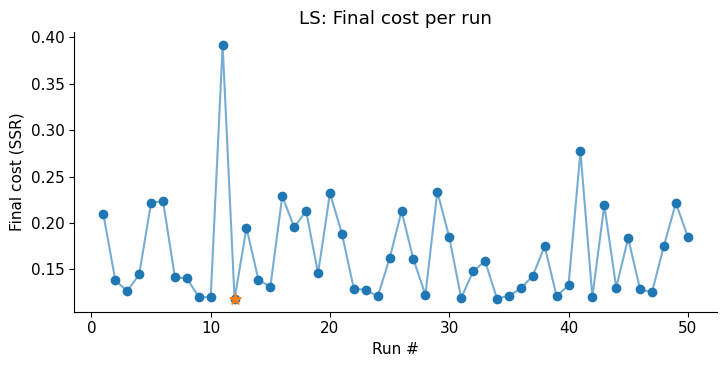

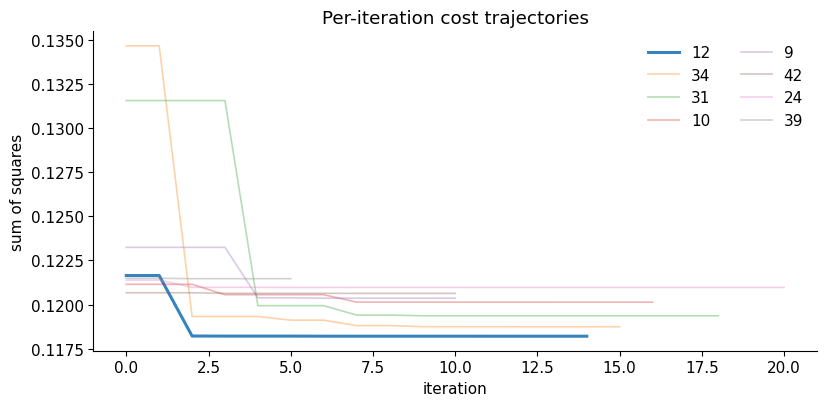

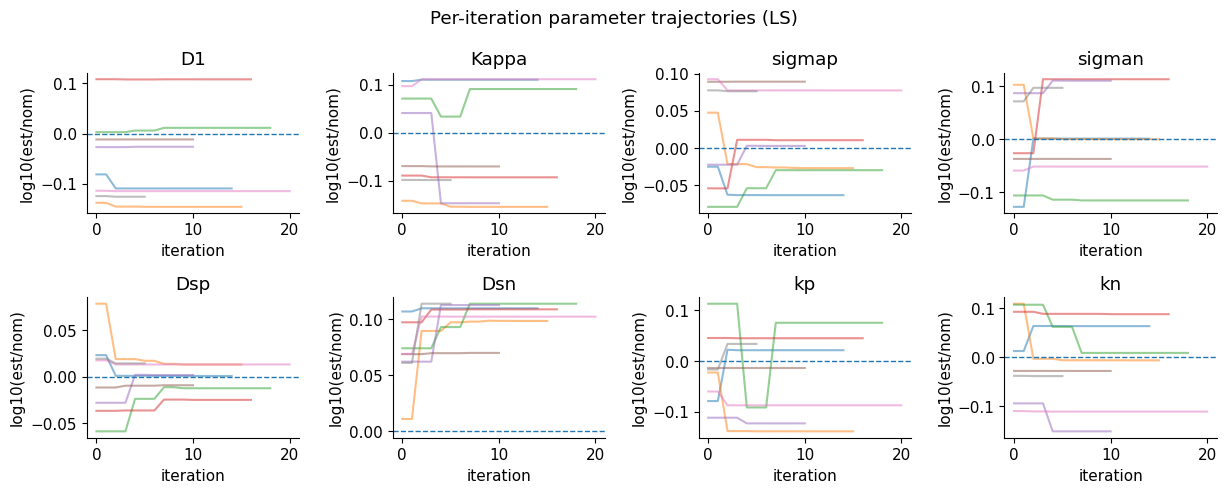

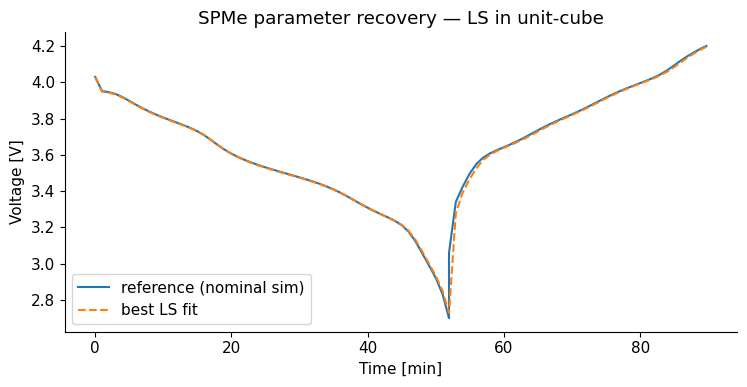


Best-fit vs nominal (relative errors):
  D1     : est=5.62656e-10, nominal=7.2296e-10, rel_err=2.217e-01
  Kappa  : est=1.3931, nominal=1.0794, rel_err=2.906e-01
  sigmap : est=0.175286, nominal=0.2029, rel_err=1.361e-01
  sigman : est=150.932, nominal=150.5, rel_err=2.868e-03
  Dsp    : est=5.21237e-15, nominal=5.2e-15, rel_err=2.378e-03
  Dsn    : est=5.11815e-14, nominal=3.975e-14, rel_err=2.876e-01
  kp     : est=9.06081e-12, nominal=8.6225e-12, rel_err=5.083e-02
  kn     : est=6.90296e-13, nominal=5.9673e-13, rel_err=1.568e-01
[LS] ||residual||_2 = 0.343812, status: 3


In [10]:
"""
SPMe Parameter Identification — Minimal LS (unit-cube)
------------------------------------------------------
What this script does (end-to-end):
  1) Builds a PyBaMM SPMe simulation with a simple CC (discharge→charge) experiment.
  2) Generates a synthetic "measured" voltage trace using nominal parameters (truth).
  3) Runs multi-start bounded least-squares in a unit-cube x ∈ [0,1]^n
     (affine-mapped to physical parameter ranges using ±pct around nominal).
  4) Prints a compact run summary and sanity-checks initial guesses.
  5) Plots: (a) final cost per run, (b) per-iteration cost paths (best K),
     (c) per-iteration parameter trajectories (grid), (d) best-fit overlay.

Key ideas:
  • All decision variables live in [0,1] so you avoid wildly different orders of magnitude.
  • Physical parameters are obtained by: P_i = lo_i + x_i * (hi_i - lo_i).

Dependencies:
  pip install pybamm scipy numpy matplotlib

Notes:
  • To use real measurements, replace the synthetic (t_meas, V_meas) block with your arrays.
  • Keep your vary_keys short initially for speed, then expand.
"""
from __future__ import annotations
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
import pybamm

# -----------------------------
# 0) Plotting defaults
# -----------------------------
plt.rcParams.update({
    "figure.figsize": (7.6, 4.4),
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# --------------------------------------
# 1) Parameters (nominal truth) & keys
# --------------------------------------
# Variables to estimate (kept small & focused)
vary_keys = [
    "D1", "Kappa", "sigmap", "sigman", "Dsp", "Dsn", "kp", "kn"
]

params_nominal = dict(
    # Geometry
    Ln=85.2e-6, Ls=12e-6, Lp=75.6e-6,
    A=0.11,

    # Mesh resolution (used via var_pts below)
    Nx=80, Nr=20,

    # Porosities
    eps_e={"n": 0.25, "s": 0.47, "p": 0.335},

    # Transport & kinetics (these are our targets to estimate)
    D1=7.2296e-10,
    Kappa=1.0794,
    sigmap=0.2029,
    sigman=150.5,
    Dsp=5.2e-15,
    Dsn=3.975e-14,
    kp=8.6225e-12,
    kn=5.9673e-13,

    # Particle radii
    Rp_n=5.86e-6, Rp_p=5.22e-6,

    # Concentration caps & ICs (via stoich)
    csmax_n=29583.0, csmax_p=51765.0,
    tplus=0.363,
    theta_n0=0.90, theta_p0=0.27,

    # Experiment
    n_cycles=1,
    I_cc=5.0, Vmin=2.7, Vmax=4.2, dt=0.05,
)

# Bounds width (±pct around nominal)
BOUNDS_PCT = 0.30  # 30% wide box around each nominal value

# --------------------------------------
# 2) PyBaMM mapping & simulation helpers
# --------------------------------------

def build_params_from_dict(d: dict) -> pybamm.ParameterValues:
    base = pybamm.ParameterValues("Chen2020")
    c_n0 = d["theta_n0"] * d["csmax_n"]
    c_p0 = d["theta_p0"] * d["csmax_p"]
    base.update({
        # geometry & area
        "Negative electrode thickness [m]": d["Ln"],
        "Separator thickness [m]": d["Ls"],
        "Positive electrode thickness [m]": d["Lp"],
        "Electrode area [m2]": d["A"],
        # porosities
        "Negative electrode porosity": d["eps_e"]["n"],
        "Separator porosity": d["eps_e"]["s"],
        "Positive electrode porosity": d["eps_e"]["p"],
        # electrolyte transport (assume constant here)
        "Electrolyte diffusivity [m2.s-1]": d["D1"],
        "Electrolyte conductivity [S.m-1] (ref)": d["Kappa"],
        "Cation transference number": d["tplus"],
        # solid transport
        "Negative electrode diffusivity [m2.s-1]": d["Dsn"],
        "Positive electrode diffusivity [m2.s-1]": d["Dsp"],
        # electronic conductivities
        "Negative electrode conductivity [S.m-1]": d["sigman"],
        "Positive electrode conductivity [S.m-1]": d["sigmap"],
        # particle radii
        "Negative particle radius [m]": d["Rp_n"],
        "Positive particle radius [m]": d["Rp_p"],
        # concentrations & ICs
        "Maximum concentration in negative electrode [mol.m-3]": d["csmax_n"],
        "Maximum concentration in positive electrode [mol.m-3]": d["csmax_p"],
        "Initial concentration in negative electrode [mol.m-3]": c_n0,
        "Initial concentration in positive electrode [mol.m-3]": c_p0,
        # kinetics
        "Negative electrode reaction rate constant [m2.5 mol-0.5 s-1]": d["kn"],
        "Positive electrode reaction rate constant [m2.5 mol-0.5 s-1]": d["kp"],
        # isothermal
        "Ambient temperature [K]": 298.15,
        "Reference temperature [K]": 298.15,
    }, check_already_exists=False)
    return base


def make_experiment(d: dict) -> pybamm.Experiment:
    I, Vmin, Vmax, n_cycles = float(d["I_cc"]), d["Vmin"], d["Vmax"], int(d.get("n_cycles", 1))
    steps = [f"Discharge at {I} A until {Vmin} V", f"Charge at {I} A until {Vmax} V"] * n_cycles
    return pybamm.Experiment(steps)


def run_spme(d: dict):
    model = pybamm.lithium_ion.SPMe(options={
        "surface form": "algebraic", "thermal": "isothermal",
        "SEI": "none", "lithium plating": "none",
    })
    param = build_params_from_dict(d)

    var_pts = {"x_n": 20, "x_s": 15, "x_p": 20, "r_n": 30, "r_p": 30}
    experiment = make_experiment(d)

    dt = float(d.get("dt", 0.05))
    try:
        solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-6, dt_max=dt)
    except Exception:
        solver = pybamm.ScipySolver(atol=1e-6, rtol=1e-6, mode="safe")

    sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment,
                             var_pts=var_pts, solver=solver)
    sol = sim.solve()
    return sol, sim


def simulate_voltage(pd: dict):
    sol, _ = run_spme(pd)
    t = sol["Time [s]"].entries
    V = sol["Terminal voltage [V]"].entries
    I = sol["Current [A]"].entries
    return t, V, I


def align_to(t_src, y_src, t_dst, fill_value="extrapolate"):
    f = interp1d(t_src, y_src, kind="linear", bounds_error=False, fill_value=fill_value)
    return f(t_dst)

# -------------------------------------------------
# 3) Unit-cube mapping and residuals for LS
# -------------------------------------------------

def make_bounds_from_template(template: dict, keys: list[str], pct: float = 0.30):
    lo = np.array([template[k] * (1 - pct) for k in keys], float)
    hi = np.array([template[k] * (1 + pct) for k in keys], float)
    return lo, hi


def unit_to_physical(template: dict, x: np.ndarray, lo: np.ndarray, hi: np.ndarray, keys=vary_keys) -> dict:
    d = dict(template)
    for k, xv, l, h in zip(keys, x, lo, hi):
        d[k] = float(l + xv * (h - l))
    return d


def residuals_V(x: np.ndarray, V_meas: np.ndarray, t_meas: np.ndarray,
                template: dict, lo: np.ndarray, hi: np.ndarray, keys=vary_keys,
                penalty: float = 1e3) -> np.ndarray:
    try:
        pd = unit_to_physical(template, x, lo, hi, keys)
        t_sim, V_sim, _ = simulate_voltage(pd)
    except Exception:
        return np.full_like(V_meas, penalty, float)

    if (t_sim.shape != t_meas.shape) or (not np.allclose(t_sim, t_meas)):
        V_sim = align_to(t_sim, V_sim, t_meas)
    return (V_meas - V_sim).astype(float)

# -------------------------------------------------
# 4) Least-squares (multi-start) + logging
# -------------------------------------------------

def run_least_squares(t_meas: np.ndarray, V_meas: np.ndarray,
                      template: dict, lo: np.ndarray, hi: np.ndarray, keys=vary_keys,
                      n_starts: int = 8, seed: int | None = 0,
                      max_nfev: int = 80, tol: float = 1e-9,
                      record_path: bool = True):
    rng = np.random.default_rng(seed)
    n = len(keys)
    bounds = (np.zeros(n), np.ones(n))  # unit cube

    best = None
    runs: list[dict] = []

    for i in range(1, n_starts + 1):
        x0 = rng.uniform(0.0, 1.0, size=n)
        x_path: list[np.ndarray] = []
        cost_path: list[float] = []

        def fun_wrapped(x):
            r = residuals_V(x, V_meas, t_meas, template, lo, hi, keys)
            if record_path:
                c = float(np.dot(r, r))
                if not cost_path or c < cost_path[-1] - 1e-12 * max(1.0, abs(cost_path[-1])):
                    x_path.append(np.array(x, float))
                    cost_path.append(c)
            return r

        res = least_squares(fun_wrapped, x0, bounds=bounds, method="trf",
                             loss="linear", ftol=tol, xtol=tol, gtol=tol, max_nfev=max_nfev)
        xhat = res.x
        est_params = unit_to_physical(template, xhat, lo, hi, keys)
        runs.append({
            "start": i,
            "x0": x0,
            "xhat": xhat,
            "residual_norm_2": float(np.linalg.norm(res.fun)),
            "status": int(res.status),
            "est_params": {k: float(est_params[k]) for k in keys},
            "x_path": x_path,
            "cost_path": cost_path,
        })

        print(f"[start {i}/{n_starts}] ||res||_2={np.linalg.norm(res.fun):.6g} status={res.status}")
        if (best is None) or (np.linalg.norm(res.fun) < np.linalg.norm(best.fun)):
            best = res

    best_est = unit_to_physical(template, best.x, lo, hi, keys)
    return best_est, best, runs

# -------------------------------------------------
# 5) Summaries & Plots
# -------------------------------------------------

def print_runs_summary(runs, keys=vary_keys):
    print("\n=== Multi-start summary ===")
    header = ["start", "||res||_2"] + [f"est_{k}" for k in keys]
    print(" | ".join(f"{h:>14s}" for h in header))
    for r in runs:
        row = [f"{r['start']:>14d}", f"{r['residual_norm_2']:>14.6g}"]
        row += [f"{r['est_params'][k]:>14.6g}" for k in keys]
        print(" | ".join(row))


def check_initial_guesses(runs):
    X0 = np.stack([r["x0"] for r in runs])
    print("x0 per-dimension min:", np.min(X0, axis=0))
    print("x0 per-dimension max:", np.max(X0, axis=0))


def _final_cost(r):
    return float(r.get("cost_path", [r["residual_norm_2"]**2])[-1])


def top_k_runs_by_cost(runs, k=8):
    return sorted(runs, key=_final_cost)[:k]


def plot_run_vs_final_cost(runs, logy=False, title="LS: Final cost per run"):
    xs = [r["start"] for r in runs]
    ys = [_final_cost(r) for r in runs]
    order = np.argsort(xs)
    xs, ys = np.array(xs)[order], np.array(ys)[order]
    plt.figure(figsize=(7.4, 3.8))
    plt.scatter(xs, ys)
    plt.plot(xs, ys, alpha=0.6)
    if logy: plt.yscale("log")
    plt.xlabel("Run #"); plt.ylabel("Final cost (SSR)"); plt.title(title)
    i_best = int(np.argmin(ys))
    plt.scatter([xs[i_best]], [ys[i_best]], s=70, marker="*", zorder=5)
    plt.tight_layout(); plt.show()


def plot_cost_paths(runs, logy=False, legend_loc="upper right"):
    plt.figure(figsize=(8.4, 4.2))
    # best-run highlighting
    best_idx = int(np.argmin([_final_cost(r) for r in runs]))
    for i, r in enumerate(runs):
        cp = r.get("cost_path", [])
        if not cp: continue
        it = np.arange(len(cp))
        kw = dict(alpha=0.9, linewidth=2.2) if i == best_idx else dict(alpha=0.35, linewidth=1.2)
        plt.plot(it, cp, label=str(r.get("start", i+1)), **kw)
    if logy: plt.yscale("log")
    plt.xlabel("iteration"); plt.ylabel("sum of squares")
    plt.title("Per-iteration cost trajectories")
    plt.legend(loc=legend_loc, frameon=False, ncol=2)
    plt.tight_layout(); plt.show()


def plot_param_trajectories_grid(runs, keys=vary_keys, template=None, lo=None, hi=None, scale="logrel"):
    n_params = len(keys)
    ncols = 4
    nrows = math.ceil(n_params / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.1*ncols, 2.5*nrows), sharex=False)
    axes = np.atleast_1d(axes).ravel()

    def x_to_phys(x):
        return unit_to_physical(template, x, lo, hi, keys)

    for pi, k in enumerate(keys):
        ax = axes[pi]
        for r in runs:
            X = r.get("x_path", [])
            if not X: continue
            phys = [x_to_phys(xk)[k] for xk in X]
            y = np.array(phys, float)
            if scale == "logrel" and template is not None:
                nom = template[k] if template[k] != 0 else 1.0
                y = np.log10(np.clip(y / nom, 1e-300, 1e300))
                ax.set_ylabel("log10(est/nom)")
            ax.plot(np.arange(len(y)), y, alpha=0.5)
        ax.set_title(k); ax.set_xlabel("iteration")
        if scale == "logrel": ax.axhline(0.0, ls="--", lw=1.0)

    for j in range(n_params, nrows*ncols):
        fig.delaxes(axes[j])
    fig.suptitle("Per-iteration parameter trajectories (LS)")
    fig.tight_layout(); plt.show()

# ---------------------------------
# 6) Demo main — synthetic data
# ---------------------------------
if __name__ == "__main__":
    # Bounds in physical space from nominal
    lo_phys, hi_phys = make_bounds_from_template(params_nominal, vary_keys, pct=BOUNDS_PCT)

    # Synthetic measurement (clean)
    t_meas, V_meas, _ = simulate_voltage(params_nominal)

    # Fit (multi-start LS in unit-cube)
    best_params, res_best, runs = run_least_squares(
        t_meas=t_meas, V_meas=V_meas,
        template=params_nominal, lo=lo_phys, hi=hi_phys, keys=vary_keys,
        n_starts=50, seed=None, max_nfev=80, tol=1e-9,
    )

    # Summaries
    print_runs_summary(runs, keys=vary_keys)
    check_initial_guesses(runs)

    # Plots (final-cost per run, then top-K cost paths)
    plot_run_vs_final_cost(runs, logy=False)
    bestK = top_k_runs_by_cost(runs, k=min(8, len(runs)))
    plot_cost_paths(bestK, logy=False)

    # Parameter trajectories grid (using best K for clarity)
    plot_param_trajectories_grid(bestK, keys=vary_keys, template=params_nominal,
                                 lo=lo_phys, hi=hi_phys, scale="logrel")

    # Best-fit overlay vs reference
    from numpy import allclose
    t_fit, V_fit, _ = simulate_voltage(best_params)
    if (t_fit.shape != t_meas.shape) or (not allclose(t_fit, t_meas)):
        V_fit = align_to(t_fit, V_fit, t_meas)

    plt.figure(figsize=(7.6, 4.0))
    plt.plot(t_meas/60, V_meas, label="reference (nominal sim)")
    plt.plot(t_meas/60, V_fit, "--", label="best LS fit")
    plt.xlabel("Time [min]"); plt.ylabel("Voltage [V]")
    plt.title("SPMe parameter recovery — LS in unit-cube")
    plt.legend(); plt.tight_layout(); plt.show()

    # Print best-fit vs nominal
    print("\nBest-fit vs nominal (relative errors):")
    for k in vary_keys:
        nom = params_nominal[k]
        rel = abs(best_params[k] - nom) / (abs(nom) if nom != 0 else 1.0)
        print(f"  {k:7s}: est={best_params[k]:.6g}, nominal={nom:.6g}, rel_err={rel:.3e}")
    print(f"[LS] ||residual||_2 = {np.linalg.norm(res_best.fun):.6g}, status: {res_best.status}")

At t = 51.8519 and h = 1.00442e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 21.552 and h = 1.51921e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 6.40205 and h = 1.33589e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 6.40204 and h = 5.68011e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.61454 and h = 8.82334e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.720788 and h = 9.69235e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.720788 and h = 1.17362e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.247351 and h = 9.82323e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.8519 and h = 3.91888e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 21.552 and h = 8.56148e-14, the corrector convergence failed repeatedly or with |h| = hmin.

[start 1/50] ||res||_2=0.476795 status=3
[start 2/50] ||res||_2=621.671 status=3
[start 3/50] ||res||_2=0.547535 status=3
[start 4/50] ||res||_2=0.416647 status=3


2025-09-15 06:50:40.511 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 06:50:43.425 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 06:50:45.908 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 06:50:48.099 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 06:50:50.536 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 06:50:53.156 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step

[start 5/50] ||res||_2=5.42301 status=3
[start 6/50] ||res||_2=0.535319 status=3


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
At t = 0.0582667 and h = 5.13518e-14, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:05:54.854 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Maximum number of decreased steps occurred at t=480.0 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=0.946875) and/or reducing the size of the time steps or period of the experiment. Set `return_solution_if_fai

[start 7/50] ||res||_2=9591.66 status=1


At t = 0.141961 and h = 1.86048e-10, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:06:47.914 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.
At t = 0.143283 and h = 3.50387e-10, the corrector convergence failed repeatedly or with |h| = hmin.


[start 8/50] ||res||_2=729.116 status=3
[start 9/50] ||res||_2=0.467785 status=3
[start 10/50] ||res||_2=1.10566 status=3


At t = 26.0549 and h = 3.24528e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 26.106 and h = 3.47012e-07, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:18:03.064 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.
2025-09-15 07:18:05.682 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
At t = 26.055 and h = 3.2454e-07, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:18:08.058 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 0

[start 11/50] ||res||_2=311.896 status=3


At t = 22.8405 and h = 3.66524e-10, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:19:13.065 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 07:19:16.429 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
At t = 22.8405 and h = 3.66523e-10, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:19:19.048 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 07:19:22.072 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
At t = 22.8405 and h = 3.66524e-10, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:19:24.569 - [WARNI

[start 12/50] ||res||_2=153.561 status=3


At t = 47.3535 and h = 2.81004e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 45.2838 and h = 3.58189e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 42.0066 and h = 7.8715e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 42.0066 and h = 7.86909e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 42.0066 and h = 7.86896e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 42.0066 and h = 7.8714e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 42.0066 and h = 7.87204e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 42.0066 and h = 7.87119e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 42.0067 and h = 7.87253e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 42.0066 and h = 7.87227e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At

[start 13/50] ||res||_2=12.9933 status=3
[start 14/50] ||res||_2=0.363642 status=3


2025-09-15 07:28:12.196 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 07:28:14.786 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 07:28:16.816 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 07:28:18.900 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 07:28:21.603 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 07:28:23.981 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 07:28:26.216 - [ERROR] callbacks.on_experiment_

[start 15/50] ||res||_2=9591.66 status=1


At t = 37.473 and h = 8.0412e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 42.3048 and h = 4.6641e-07, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:28:50.733 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.
At t = 37.4814 and h = 8.05699e-07, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:28:59.333 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve ret

[start 16/50] ||res||_2=29359.8 status=3


At t = 7.02551 and h = 1.36009e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 7.02552 and h = 9.61981e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 7.02557 and h = 2.5496e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 7.02556 and h = 8.86465e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.23806 and h = 1.14199e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.3443, repeated recoverable residual errors.
At t = 0.397425 and h = 7.66743e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.397424 and h = 1.00175e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.160707 and h = 2.22287e-14, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:30:35.476 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../ca

[start 17/50] ||res||_2=0.354503 status=3
[start 18/50] ||res||_2=0.499605 status=3


At t = 0.217812 and h = 7.01985e-12, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 07:46:34.152 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.


[start 19/50] ||res||_2=1811.6 status=3


2025-09-15 07:48:40.799 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
At t = 57.9586 and h = 1.3008e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 27.659, repeated recoverable residual errors.
At t = 12.5091 and h = 1.7557e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 4.93401 and h = 3.32377e-29, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.14651 and h = 1.14538e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.14651 and h = 9.22359e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.199636 and h = 1.02662e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.199637 and h = 5.13073e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.199637, repeated recoverable residual errors.
At t = 0.0812744 and h = 2.55667e-1

[start 20/50] ||res||_2=0.668298 status=3


At t = 17.6659 and h = 2.63433e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 17.6659 and h = 2.63434e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.51618 and h = 7.11962e-13, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 08:06:07.434 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.
At t = 17.6659 and h = 2.63433e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 17.6659 and h = 2.63434e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.51618 and h = 7.11962e-13, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 08:06:14.913

[start 21/50] ||res||_2=8.82352 status=3
[start 22/50] ||res||_2=0.520074 status=3


2025-09-15 08:15:57.689 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:16:00.464 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:16:02.419 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:16:04.544 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:16:06.518 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:16:08.376 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:16:10.378 - [ERROR] callbacks.on_experiment_

[start 23/50] ||res||_2=9591.66 status=1
[start 24/50] ||res||_2=0.394598 status=3


2025-09-15 08:19:48.133 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:19:51.599 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:19:54.028 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:19:56.354 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:19:58.749 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:01.457 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:03.835 - [ERROR] callbacks.on_experiment_

[start 25/50] ||res||_2=9591.66 status=1


2025-09-15 08:20:13.978 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:16.835 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:19.043 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:21.634 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:24.076 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:26.478 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:28.893 - [ERROR] callbacks.on_experiment_

[start 26/50] ||res||_2=9591.66 status=1


2025-09-15 08:20:35.793 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
At t = 32.4848 and h = 3.73298e-07, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 08:20:39.222 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:41.458 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:43.619 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:46.050 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 08:20:48.250 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which e

[start 27/50] ||res||_2=9591.66 status=1


At t = 32.2318 and h = 1.61006e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 32.2328 and h = 1.61012e-07, the corrector convergence failed repeatedly or with |h| = hmin.


[start 28/50] ||res||_2=163.489 status=3


2025-09-15 08:28:39.593 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 08:28:41.753 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 08:28:43.449 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 08:28:45.102 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 08:28:46.945 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 08:28:48.766 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step

[start 29/50] ||res||_2=0.672369 status=3


At t = 20.1257 and h = 3.16632e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 20.1257 and h = 3.42195e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 4.97569 and h = 2.42415e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 4.97567 and h = 3.9113e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.18817 and h = 1.03987e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.18817 and h = 4.7063e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.241284 and h = 6.34198e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.241285 and h = 1.46014e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 20.1257 and h = 2.72574e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 20.1257 and h = 3.02074e-14, the corrector convergence failed repeatedly or with |h| = hmin.


[start 30/50] ||res||_2=2.17925 status=3
[start 31/50] ||res||_2=0.378497 status=3


At t = 28.1414 and h = 2.01937e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 28.1414 and h = 6.98009e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 12.9914 and h = 3.55782e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 5.41635 and h = 2.97211e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.62886 and h = 1.18358e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.62886 and h = 1.83241e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.681983 and h = 9.53371e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.208544 and h = 1.62079e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.208543 and h = 2.85814e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0901872, repeated recoverable residual errors.
At t = 0.0310048 and h = 2.46332e-13, the

[start 32/50] ||res||_2=0.408863 status=3


At t = 0.00770561 and h = 7.74897e-11, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 08:51:11.534 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.


[start 33/50] ||res||_2=673.453 status=3


At t = 2.12878, repeated recoverable residual errors.
At t = 2.12878, repeated recoverable residual errors.
At t = 2.12878 and h = 8.19489e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.12878 and h = 5.33783e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.12878 and h = 1.84186e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.23503 and h = 6.40965e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.235031 and h = 4.41828e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.235031 and h = 6.61583e-24, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.235031 and h = 1.20985e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.12878 and h = 1.74182e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.12878 and h = 1.04621e-19, the corrector convergence failed repeatedly or with |

[start 34/50] ||res||_2=1.13018 status=3
[start 35/50] ||res||_2=0.430167 status=3


At t = 15.3483, repeated recoverable residual errors.
At t = 15.3487 and h = 4.63751e-16, the corrector convergence failed repeatedly or with |h| = hmin.
The linesearch algorithm failed with too small a step.
At t = 0.198696 and h = 2.27786e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.198696 and h = 3.65282e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.198696 and h = 3.36255e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.198697 and h = 3.80379e-23, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.198697 and h = 1.85501e-17, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 09:01:36.095 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Maximum number of decreased steps occurred at t=435.15 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [Ida

[start 36/50] ||res||_2=0.388013 status=3


At t = 0.0312332 and h = 2.05715e-11, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 09:04:21.217 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.


[start 37/50] ||res||_2=786.793 status=3


At t = 0.0113891 and h = 1.23702e-10, the corrector convergence failed repeatedly or with |h| = hmin.


[start 38/50] ||res||_2=646.201 status=3


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2025-09-15 09:11:49.918 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Maximum number of decreased steps occurred at t=190.1002349882201 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=60.60000000000003) and/or reducing the size of the time steps or period of the exp

[start 39/50] ||res||_2=55.5892 status=3


2025-09-15 09:13:39.944 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:41.813 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:43.185 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:44.471 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:45.701 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:47.029 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:48.452 - [ERROR] callbacks.on_experiment_

[start 40/50] ||res||_2=9591.66 status=1


2025-09-15 09:13:52.481 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:54.118 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:55.366 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:57.016 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:58.381 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:13:59.621 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 09:14:00.852 - [ERROR] callbacks.on_experiment_

[start 41/50] ||res||_2=9591.66 status=1


At t = 41.2315 and h = 3.53728e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 10.9315 and h = 7.74747e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 10.9315 and h = 2.46074e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.3565 and h = 8.772e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.3565 and h = 1.55927e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.46275 and h = 4.88777e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.515875 and h = 5.55487e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 41.2315 and h = 2.52394e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 10.9315 and h = 2.45071e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 10.9315 and h = 2.32787e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At 

[start 42/50] ||res||_2=0.383476 status=3


At t = 29.6545 and h = 2.04861e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 29.6551 and h = 1.20486e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 14.5052 and h = 4.87287e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 6.93019 and h = 7.17212e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.14269 and h = 1.0451e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.24894 and h = 7.9767e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.302066 and h = 2.173e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.302066 and h = 1.6745e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 29.6545 and h = 1.59969e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 29.6551 and h = 3.62671e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At 

[start 43/50] ||res||_2=0.541824 status=3
[start 44/50] ||res||_2=0.424498 status=3


At t = 53.1211 and h = 6.39806e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 22.8215 and h = 4.46545e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 7.67153 and h = 3.61132e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0964947 and h = 2.7006e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0964949 and h = 7.73657e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0964957 and h = 2.75318e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0964956 and h = 1.97625e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0964948 and h = 8.59313e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0964955 and h = 2.7452e-14, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 09:47:13.454 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Ma

[start 45/50] ||res||_2=9591.66 status=1


At t = 13.336 and h = 1.89429e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 13.3359 and h = 1.52926e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 13.3359, repeated recoverable residual errors.
At t = 5.76092 and h = 1.43579e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.97342 and h = 2.08057e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0796687 and h = 3.37335e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0796687 and h = 2.4904e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.079668 and h = 1.07278e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0796682 and h = 7.56253e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.079669 and h = 5.08128e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0204868 and h = 2.27832e-13, th

[start 46/50] ||res||_2=12.9098 status=3


At t = 3.21345 and h = 1.25706e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.21355 and h = 2.73231e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.21355, repeated recoverable residual errors.
At t = 3.21354 and h = 2.29783e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.21354 and h = 1.59035e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.31979 and h = 2.57222e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.372916 and h = 4.16283e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.372915 and h = 1.74016e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.136196 and h = 2.29598e-13, the corrector convergence failed repeatedly or with |h| = hmin.


[start 47/50] ||res||_2=0.456309 status=3


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


[start 48/50] ||res||_2=9.43247 status=3
[start 49/50] ||res||_2=1240.57 status=3


2025-09-15 10:11:49.117 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
At t = 0.0032816 and h = 1.06442e-10, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 10:12:25.637 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.
At t = 0.00286204 and h = 9.64554e-11, the corrector convergence failed repeatedly or with |h| = hmin.


[start 50/50] ||res||_2=48.1388 status=3
=== Multi-start summary ===
         start |      ||res||_2 |         est_D1 |      est_Kappa |     est_sigmap |     est_sigman |        est_Dsp |        est_Dsn |         est_kp |         est_kn
             1 |       0.476795 |    2.34913e-09 |       0.804464 |       0.279582 |        6682.09 |    4.71251e-15 |    2.99179e-14 |    1.05726e-14 |    2.45827e-14
             2 |        621.671 |    6.55386e-12 |        0.99072 |        2.21784 |        11780.5 |    1.59864e-15 |    4.76524e-13 |    2.39258e-10 |    1.03613e-11
             3 |       0.547535 |    9.59288e-09 |      0.0215824 |       0.293524 |        1288.65 |    8.84528e-15 |    2.54744e-14 |    1.16044e-12 |    5.57088e-12
             4 |       0.416647 |    4.19459e-10 |       0.115124 |        0.16146 |        567.407 |    5.08221e-15 |    1.45611e-13 |    1.56208e-13 |    8.24877e-12
             5 |        5.42301 |    5.70457e-09 |       0.184209 |     0.00185004 |       

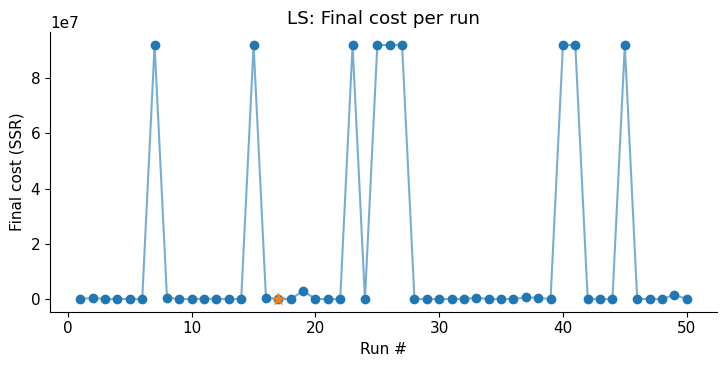

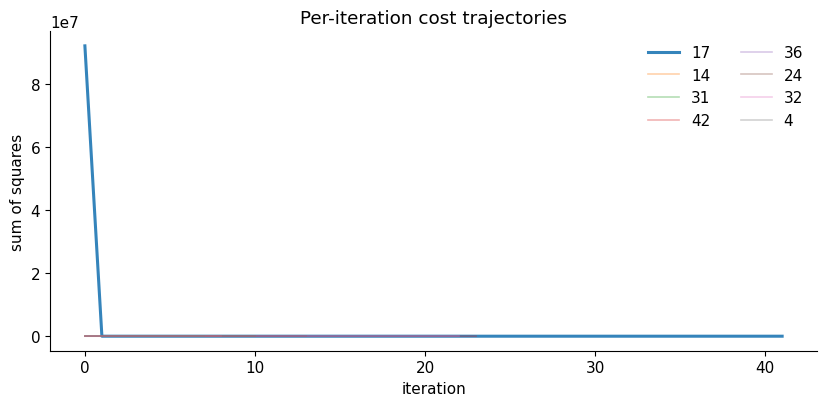

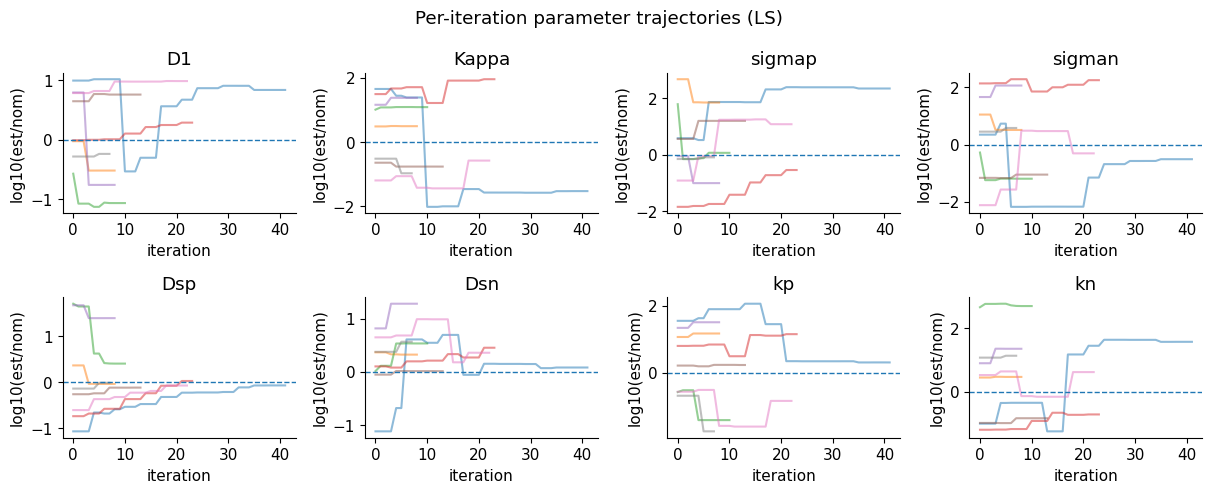

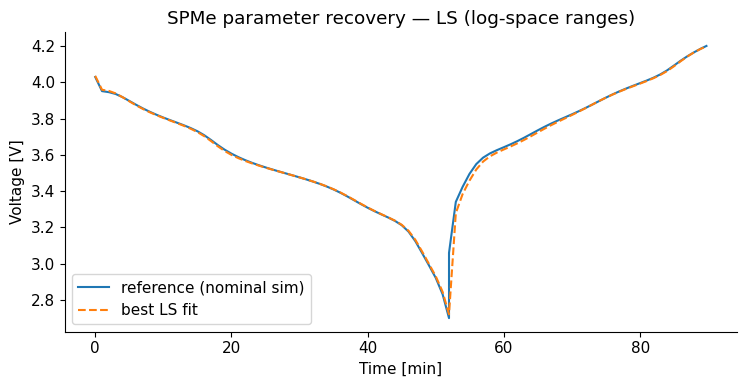

Best-fit vs baseline (relative errors):
  D1     : est=5.00241e-09, baseline=7.2296e-10, rel_err=5.919e+00
  Kappa  : est=0.0320567, baseline=1.0794, rel_err=9.703e-01
  sigmap : est=44.076, baseline=0.2029, rel_err=2.162e+02
  sigman : est=46.4061, baseline=150.5, rel_err=6.917e-01
  Dsp    : est=4.45966e-15, baseline=5.2e-15, rel_err=1.424e-01
  Dsn    : est=4.78396e-14, baseline=3.975e-14, rel_err=2.035e-01
  kp     : est=1.77152e-11, baseline=8.6225e-12, rel_err=1.055e+00
  kn     : est=2.26419e-11, baseline=5.9673e-13, rel_err=3.694e+01
[LS] ||residual||_2 = 0.354503, status: 3


In [11]:
"""
SPMe Parameter Identification — Minimal LS (unit-cube, no ±pct box)
-------------------------------------------------------------------
End-to-end pipeline with **no ±30% affine box around nominal**. Instead, the
optimizer works in a unit cube x ∈ [0,1]^n and parameters are mapped from x
via **fixed log-space ranges** chosen for reasonable physical magnitudes.

What you get:
  1) Build PyBaMM SPMe + synthetic measurement V(t) (easy to swap for real).
  2) Multi-start bounded least-squares in x ∈ [0,1]^n (initial guesses ∈ [0,1]).
  3) Summary printout + sanity-check of x0 bounds.
  4) Plots: final cost per run, per-iteration cost paths (best K),
     parameter trajectories grid, and best-fit overlay.

Why log-ranges? Keeps variables O(1) and avoids mixing 1e-14 with 1e+2; but we
no longer rely on a nominal dict or a ±pct box.

Dependencies:  pip install pybamm scipy numpy matplotlib
"""
from __future__ import annotations
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
import pybamm

# -----------------------------
# 0) Plotting defaults
# -----------------------------
plt.rcParams.update({
    "figure.figsize": (7.6, 4.4),
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# --------------------------------------
# 1) Parameters (nominal for synthetic data only) & keys
# --------------------------------------
# Variables to estimate
vary_keys = [
    "D1", "Kappa", "sigmap", "sigman", "Dsp", "Dsn", "kp", "kn"
]

# Fixed log-space ranges (decades) independent of nominal values
# p = 10 ** (log10_min + x * (log10_max - log10_min)),  where x∈[0,1]
LOG10_RANGES = {
    # electrolyte
    "D1":    (-12.0, -8.0),    # [1e-12, 1e-8] m^2/s
    "Kappa": (-2.0,  2.0),     # [1e-2, 1e+2] S/m
    # solids
    "sigmap":(-3.0,  2.0),     # [1e-3, 1e+2] S/m
    "sigman":( 0.0,  5.0),     # [1e+0, 1e+5] S/m
    "Dsp":  (-16.0, -12.0),    # [1e-16, 1e-12] m^2/s
    "Dsn":  (-16.0, -12.0),    # [1e-16, 1e-12] m^2/s
    # kinetics (BV)
    "kp":   (-14.0,  -9.0),    # [1e-14, 1e-9]  m^{2.5} mol^{-0.5} s^{-1}
    "kn":   (-14.0,  -9.0),
}

# Baseline dictionary (used for geometry, ICs, etc.; not for bounds)
params_base = dict(
    # Geometry
    Ln=85.2e-6, Ls=12e-6, Lp=75.6e-6,
    A=0.11,
    # Mesh resolution (used via var_pts below)
    Nx=80, Nr=20,
    # Porosities
    eps_e={"n": 0.25, "s": 0.47, "p": 0.335},
    # Nominal transport & kinetics (only for synthetic data generation below)
    D1=7.2296e-10,
    Kappa=1.0794,
    sigmap=0.2029,
    sigman=150.5,
    Dsp=5.2e-15,
    Dsn=3.975e-14,
    kp=8.6225e-12,
    kn=5.9673e-13,
    # Particle radii
    Rp_n=5.86e-6, Rp_p=5.22e-6,
    # Concentration caps & ICs (via stoich)
    csmax_n=29583.0, csmax_p=51765.0,
    tplus=0.363,
    theta_n0=0.90, theta_p0=0.27,
    # Experiment
    n_cycles=1,
    I_cc=5.0, Vmin=2.7, Vmax=4.2, dt=0.05,
)

# --------------------------------------
# 2) PyBaMM mapping & simulation helpers
# --------------------------------------

def build_params_from_dict(d: dict) -> pybamm.ParameterValues:
    base = pybamm.ParameterValues("Chen2020")
    c_n0 = d["theta_n0"] * d["csmax_n"]
    c_p0 = d["theta_p0"] * d["csmax_p"]
    base.update({
        # geometry & area
        "Negative electrode thickness [m]": d["Ln"],
        "Separator thickness [m]": d["Ls"],
        "Positive electrode thickness [m]": d["Lp"],
        "Electrode area [m2]": d["A"],
        # porosities
        "Negative electrode porosity": d["eps_e"]["n"],
        "Separator porosity": d["eps_e"]["s"],
        "Positive electrode porosity": d["eps_e"]["p"],
        # electrolyte transport
        "Electrolyte diffusivity [m2.s-1]": d["D1"],
        "Electrolyte conductivity [S.m-1] (ref)": d["Kappa"],
        "Cation transference number": d["tplus"],
        # solid transport
        "Negative electrode diffusivity [m2.s-1]": d["Dsn"],
        "Positive electrode diffusivity [m2.s-1]": d["Dsp"],
        # electronic conductivities
        "Negative electrode conductivity [S.m-1]": d["sigman"],
        "Positive electrode conductivity [S.m-1]": d["sigmap"],
        # particle radii
        "Negative particle radius [m]": d["Rp_n"],
        "Positive particle radius [m]": d["Rp_p"],
        # concentrations & ICs
        "Maximum concentration in negative electrode [mol.m-3]": d["csmax_n"],
        "Maximum concentration in positive electrode [mol.m-3]": d["csmax_p"],
        "Initial concentration in negative electrode [mol.m-3]": c_n0,
        "Initial concentration in positive electrode [mol.m-3]": c_p0,
        # kinetics
        "Negative electrode reaction rate constant [m2.5 mol-0.5 s-1]": d["kn"],
        "Positive electrode reaction rate constant [m2.5 mol-0.5 s-1]": d["kp"],
        # isothermal
        "Ambient temperature [K]": 298.15,
        "Reference temperature [K]": 298.15,
    }, check_already_exists=False)
    return base


def make_experiment(d: dict) -> pybamm.Experiment:
    I, Vmin, Vmax, n_cycles = float(d["I_cc"]), d["Vmin"], d["Vmax"], int(d.get("n_cycles", 1))
    steps = [f"Discharge at {I} A until {Vmin} V", f"Charge at {I} A until {Vmax} V"] * n_cycles
    return pybamm.Experiment(steps)


def run_spme(d: dict):
    model = pybamm.lithium_ion.SPMe(options={
        "surface form": "algebraic", "thermal": "isothermal",
        "SEI": "none", "lithium plating": "none",
    })
    param = build_params_from_dict(d)
    var_pts = {"x_n": 20, "x_s": 15, "x_p": 20, "r_n": 30, "r_p": 30}
    experiment = make_experiment(d)
    dt = float(d.get("dt", 0.05))
    try:
        solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-6, dt_max=dt)
    except Exception:
        solver = pybamm.ScipySolver(atol=1e-6, rtol=1e-6, mode="safe")
    sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment,
                             var_pts=var_pts, solver=solver)
    sol = sim.solve()
    return sol, sim


def simulate_voltage(pd: dict):
    sol, _ = run_spme(pd)
    t = sol["Time [s]"].entries
    V = sol["Terminal voltage [V]"].entries
    I = sol["Current [A]"].entries
    return t, V, I


def align_to(t_src, y_src, t_dst, fill_value="extrapolate"):
    f = interp1d(t_src, y_src, kind="linear", bounds_error=False, fill_value=fill_value)
    return f(t_dst)

# -------------------------------------------------
# 3) Log-space mapping from x∈[0,1]^n to physical params
# -------------------------------------------------

def unit01_to_physical_logspace(template: dict, x: np.ndarray, keys=vary_keys) -> dict:
    d = dict(template)
    for k, xv in zip(keys, x):
        lo, hi = LOG10_RANGES[k]
        log10_val = lo + float(xv) * (hi - lo)
        d[k] = 10.0 ** log10_val
    return d

# -------------------------------------------------
# 4) Residuals & LS driver (multi-start)
# -------------------------------------------------

def residuals_V(x: np.ndarray, V_meas: np.ndarray, t_meas: np.ndarray,
                template: dict, keys=vary_keys, penalty: float = 1e3) -> np.ndarray:
    try:
        pd = unit01_to_physical_logspace(template, x, keys)
        t_sim, V_sim, _ = simulate_voltage(pd)
    except Exception:
        return np.full_like(V_meas, penalty, float)
    if (t_sim.shape != t_meas.shape) or (not np.allclose(t_sim, t_meas)):
        V_sim = align_to(t_sim, V_sim, t_meas)
    return (V_meas - V_sim).astype(float)


def run_least_squares(t_meas: np.ndarray, V_meas: np.ndarray,
                      template: dict, keys=vary_keys,
                      n_starts: int = 8, seed: int | None = 0,
                      max_nfev: int = 80, tol: float = 1e-9,
                      record_path: bool = True):
    rng = np.random.default_rng(seed)
    n = len(keys)
    bounds = (np.zeros(n), np.ones(n))  # unit cube [0,1]^n

    best = None
    runs: list[dict] = []

    for i in range(1, n_starts + 1):
        x0 = rng.uniform(0.0, 1.0, size=n)
        x_path: list[np.ndarray] = []
        cost_path: list[float] = []

        def fun_wrapped(x):
            r = residuals_V(x, V_meas, t_meas, template, keys)
            if record_path:
                c = float(np.dot(r, r))
                if not cost_path or c < cost_path[-1] - 1e-12 * max(1.0, abs(cost_path[-1])):
                    x_path.append(np.array(x, float))
                    cost_path.append(c)
            return r

        res = least_squares(fun_wrapped, x0, bounds=bounds, method="trf",
                             loss="linear", ftol=tol, xtol=tol, gtol=tol, max_nfev=max_nfev)
        xhat = res.x
        est_params = unit01_to_physical_logspace(template, xhat, keys)
        runs.append({
            "start": i,
            "x0": x0,
            "xhat": xhat,
            "residual_norm_2": float(np.linalg.norm(res.fun)),
            "status": int(res.status),
            "est_params": {k: float(est_params[k]) for k in keys},
            "x_path": x_path,
            "cost_path": cost_path,
        })

        print(f"[start {i}/{n_starts}] ||res||_2={np.linalg.norm(res.fun):.6g} status={res.status}")
        if (best is None) or (np.linalg.norm(res.fun) < np.linalg.norm(best.fun)):
            best = res

    best_est = unit01_to_physical_logspace(template, best.x, keys)
    return best_est, best, runs

# -------------------------------------------------
# 5) Summaries & Plots
# -------------------------------------------------

def print_runs_summary(runs, keys=vary_keys):
    print("=== Multi-start summary ===")
    header = ["start", "||res||_2"] + [f"est_{k}" for k in keys]
    print(" | ".join(f"{h:>14s}" for h in header))
    for r in runs:
        row = [f"{r['start']:>14d}", f"{r['residual_norm_2']:>14.6g}"]
        row += [f"{r['est_params'][k]:>14.6g}" for k in keys]
        print(" | ".join(row))


def check_initial_guesses(runs):
    X0 = np.stack([r["x0"] for r in runs])
    print("x0 per-dimension min:", np.min(X0, axis=0))
    print("x0 per-dimension max:", np.max(X0, axis=0))


def _final_cost(r):
    return float(r.get("cost_path", [r["residual_norm_2"]**2])[-1])


def top_k_runs_by_cost(runs, k=8):
    return sorted(runs, key=_final_cost)[:k]


def plot_run_vs_final_cost(runs, logy=False, title="LS: Final cost per run"):
    xs = [r["start"] for r in runs]
    ys = [_final_cost(r) for r in runs]
    order = np.argsort(xs)
    xs, ys = np.array(xs)[order], np.array(ys)[order]
    plt.figure(figsize=(7.4, 3.8))
    plt.scatter(xs, ys)
    plt.plot(xs, ys, alpha=0.6)
    if logy: plt.yscale("log")
    plt.xlabel("Run #"); plt.ylabel("Final cost (SSR)"); plt.title(title)
    i_best = int(np.nanargmin(ys))
    plt.scatter([xs[i_best]], [ys[i_best]], s=70, marker="*", zorder=5)
    plt.tight_layout(); plt.show()


def plot_cost_paths(runs, logy=False, legend_loc="upper right"):
    plt.figure(figsize=(8.4, 4.2))
    best_idx = int(np.argmin([_final_cost(r) for r in runs])) if runs else -1
    for i, r in enumerate(runs):
        cp = r.get("cost_path", [])
        if not cp: continue
        it = np.arange(len(cp))
        kw = dict(alpha=0.9, linewidth=2.2) if i == best_idx else dict(alpha=0.35, linewidth=1.2)
        plt.plot(it, cp, label=str(r.get("start", i+1)), **kw)
    if logy: plt.yscale("log")
    plt.xlabel("iteration"); plt.ylabel("sum of squares")
    plt.title("Per-iteration cost trajectories")
    plt.legend(loc=legend_loc, frameon=False, ncol=2)
    plt.tight_layout(); plt.show()


def unit01_to_value_for_key(x_list, key):
    lo, hi = LOG10_RANGES[key]
    return 10.0 ** (lo + np.array(x_list, float) * (hi - lo))


def plot_param_trajectories_grid(runs, keys=vary_keys, template=None, scale="logrel"):
    n_params = len(keys)
    ncols = 4
    nrows = math.ceil(n_params / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.1*ncols, 2.5*nrows), sharex=False)
    axes = np.atleast_1d(axes).ravel()

    for pi, k in enumerate(keys):
        ax = axes[pi]
        for r in runs:
            X = r.get("x_path", [])
            if not X: continue
            # map along the path using the log-range for this key
            y = unit01_to_value_for_key([xk[vary_keys.index(k)] for xk in X], k)
            if scale == "logrel" and template is not None:
                nom = template[k] if template and (k in template) else y[0]
                y = np.log10(np.clip(y / (nom if nom != 0 else 1.0), 1e-300, 1e300))
                ax.set_ylabel("log10(est/nom)")
            ax.plot(np.arange(len(y)), y, alpha=0.5)
        ax.set_title(k); ax.set_xlabel("iteration")
        if scale == "logrel": ax.axhline(0.0, ls="--", lw=1.0)

    for j in range(n_params, nrows*ncols):
        fig.delaxes(axes[j])
    fig.suptitle("Per-iteration parameter trajectories (LS)")
    fig.tight_layout(); plt.show()

# ---------------------------------
# 6) Demo main — synthetic data
# ---------------------------------
if __name__ == "__main__":
    # Synthetic measurement (clean) from params_base
    t_meas, V_meas, _ = simulate_voltage(params_base)

    # Fit (multi-start LS in unit-cube with log-space mapping)
    best_params, res_best, runs = run_least_squares(
        t_meas=t_meas, V_meas=V_meas,
        template=params_base, keys=vary_keys,
        n_starts=50, seed=None, max_nfev=80, tol=1e-9,
    )

    # Summaries
    print_runs_summary(runs, keys=vary_keys)
    check_initial_guesses(runs)

    # Plots (final-cost per run, then top-K cost paths)
    plot_run_vs_final_cost(runs, logy=False)
    bestK = top_k_runs_by_cost(runs, k=min(8, len(runs)))
    plot_cost_paths(bestK, logy=False)

    # Parameter trajectories grid (best K)
    plot_param_trajectories_grid(bestK, keys=vary_keys, template=params_base, scale="logrel")

    # Best-fit overlay vs reference
    from numpy import allclose
    t_fit, V_fit, _ = simulate_voltage(best_params)
    if (t_fit.shape != t_meas.shape) or (not allclose(t_fit, t_meas)):
        V_fit = align_to(t_fit, V_fit, t_meas)

    plt.figure(figsize=(7.6, 4.0))
    plt.plot(t_meas/60, V_meas, label="reference (nominal sim)")
    plt.plot(t_meas/60, V_fit, "--", label="best LS fit")
    plt.xlabel("Time [min]"); plt.ylabel("Voltage [V]")
    plt.title("SPMe parameter recovery — LS (log-space ranges)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Print best-fit vs baseline
    print("Best-fit vs baseline (relative errors):")
    for k in vary_keys:
        nom = params_base[k]
        rel = abs(best_params[k] - nom) / (abs(nom) if nom != 0 else 1.0)
        print(f"  {k:7s}: est={best_params[k]:.6g}, baseline={nom:.6g}, rel_err={rel:.3e}")
    print(f"[LS] ||residual||_2 = {np.linalg.norm(res_best.fun):.6g}, status: {res_best.status}")


[start 1/50] ||res||_2=0.39715 status=3


2025-09-15 10:19:37.589 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)


[start 2/50] ||res||_2=0.428272 status=3


2025-09-15 10:26:05.889 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 3/50] ||res||_2=0.377425 status=3
[start 4/50] ||res||_2=0.357051 status=3
[start 5/50] ||res||_2=0.340545 status=3


2025-09-15 10:42:43.818 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs
At t = 58.9624 and h = 2.96523e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 24.3842 and h = 1.59533e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 9.38539 and h = 4.17935e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 4.94729 and h = 3.45361e-07, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 10:42:47.171 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.


[start 6/50] ||res||_2=0.342874 status=3


2025-09-15 10:48:50.752 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 7/50] ||res||_2=0.371698 status=3
[start 8/50] ||res||_2=0.425174 status=3
[start 9/50] ||res||_2=0.535304 status=3
[start 10/50] ||res||_2=0.405325 status=3


2025-09-15 11:09:36.077 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 11/50] ||res||_2=0.367129 status=3


2025-09-15 11:13:59.376 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs
2025-09-15 11:14:01.431 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)


[start 12/50] ||res||_2=0.348517 status=3


2025-09-15 11:18:29.166 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 13/50] ||res||_2=0.389906 status=3


At t = 0.00129944, , mxstep steps taken before reaching tout.
At t = 0.00117659, , mxstep steps taken before reaching tout.
At t = 0.00123655, , mxstep steps taken before reaching tout.
At t = 0.00124104, , mxstep steps taken before reaching tout.
At t = 0.00134212, , mxstep steps taken before reaching tout.
At t = 0.00133827, , mxstep steps taken before reaching tout.
2025-09-15 11:26:02.744 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Maximum number of decreased steps occurred at t=0.0 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_TOO_MUCH_WORK". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=60.6) and/or reducing the size of the time steps or period of the experiment. Set `return_solution_if_failed_ear

[start 14/50] ||res||_2=0.377009 status=3


2025-09-15 11:32:30.898 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 15/50] ||res||_2=0.414828 status=3


2025-09-15 16:02:20.436 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs
2025-09-15 16:02:22.199 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.


[start 16/50] ||res||_2=0.354176 status=3


2025-09-15 16:17:14.818 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver terminated unsuccessfully and maximum solution error (6.32062e+212) above tolerance (1e-06)
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


[start 17/50] ||res||_2=0.361778 status=3


2025-09-15 16:29:41.015 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)


[start 18/50] ||res||_2=0.428914 status=3
[start 19/50] ||res||_2=0.391642 status=3
[start 20/50] ||res||_2=0.412053 status=3
[start 21/50] ||res||_2=0.374836 status=3


2025-09-15 17:06:50.783 - [WARNING] simulation.solve(877): Step 'Discharge at 5.0 A until 2.7 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 17:06:51.103 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.


[start 22/50] ||res||_2=0.359103 status=3


2025-09-15 17:12:50.561 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs
2025-09-15 17:12:54.822 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)


[start 23/50] ||res||_2=0.387043 status=3


2025-09-15 17:17:29.162 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 24/50] ||res||_2=0.3675 status=3
[start 25/50] ||res||_2=0.346909 status=3
[start 26/50] ||res||_2=0.356199 status=3
[start 27/50] ||res||_2=0.3656 status=3


2025-09-15 17:35:33.159 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)
2025-09-15 17:35:35.189 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)


[start 28/50] ||res||_2=0.363563 status=3
[start 29/50] ||res||_2=0.388744 status=3
[start 30/50] ||res||_2=0.413931 status=3
[start 31/50] ||res||_2=0.392747 status=3


2025-09-15 17:55:33.739 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs
2025-09-15 17:55:35.663 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.


[start 32/50] ||res||_2=0.346589 status=3
[start 33/50] ||res||_2=0.418163 status=3


2025-09-15 18:06:37.386 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)


[start 34/50] ||res||_2=0.352984 status=3


At t = 15.5684 and h = 2.20296e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.5684 and h = 6.41391e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.5684 and h = 2.22339e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.5684 and h = 1.26822e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.5684 and h = 1.51048e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.5684 and h = 1.08012e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.5684 and h = 8.91248e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.5684 and h = 5.08412e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.5684 and h = 1.35202e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 15.5684 and h = 3.39546e-13, the corrector convergence failed repeatedly or with |h| = hmin.


[start 35/50] ||res||_2=0.407822 status=3


2025-09-15 18:17:42.136 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 36/50] ||res||_2=0.414125 status=3


2025-09-15 18:22:50.989 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 37/50] ||res||_2=0.372031 status=3


2025-09-15 18:27:12.952 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 38/50] ||res||_2=0.433639 status=3
[start 39/50] ||res||_2=0.361424 status=3


2025-09-15 18:36:05.445 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)


[start 40/50] ||res||_2=0.376897 status=3


2025-09-15 18:40:19.735 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 41/50] ||res||_2=0.3963 status=3


2025-09-15 18:46:47.381 - [WARNING] simulation.solve(877): Step 'Discharge at 5.0 A until 2.7 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.
2025-09-15 18:46:47.561 - [WARNING] simulation.solve(877): Step 'Charge at 5.0 A until 4.2 V' is infeasible at initial conditions, but skip_ok is True. Skipping step.


[start 42/50] ||res||_2=0.389809 status=3


2025-09-15 19:00:32.564 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 43/50] ||res||_2=0.386863 status=3
[start 44/50] ||res||_2=0.387811 status=3


2025-09-15 19:20:02.969 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs
2025-09-15 19:20:06.179 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)


[start 45/50] ||res||_2=0.406974 status=3


2025-09-15 19:27:33.935 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not find consistent states: Could not find acceptable solution: solver returned NaNs or Infs


[start 46/50] ||res||_2=0.361959 status=3


At t = 0 and h = 8.95046e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0 and h = 7.42582e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0 and h = 8.95047e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0 and h = 3.58019e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0 and h = 8.95046e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0 and h = 2.23761e-12, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 19:37:37.732 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Maximum number of decreased steps occurred at t=78.50918321765164 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". 

[start 47/50] ||res||_2=0.359261 status=3


2025-09-15 19:48:38.792 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Could not determine which event was triggered (possibly due to NaNs)


[start 48/50] ||res||_2=0.346909 status=3


At t = 48.6614 and h = 2.92186e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 18.2704 and h = 2.8897e-07, the corrector convergence failed repeatedly or with |h| = hmin.
2025-09-15 20:01:18.254 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.


[start 49/50] ||res||_2=0.394597 status=3
[start 50/50] ||res||_2=0.402321 status=3

=== Multi-start summary ===
         start |      ||res||_2 |         est_D1 |      est_Kappa |     est_sigmap |     est_sigman |        est_Dsp |        est_Dsn |         est_kp |         est_kn
             1 |        0.39715 |    3.50557e-10 |    1.91648e+49 |        0.17988 |    9.66044e+29 |    5.66982e-15 |    3.52742e-14 |    2.11308e-15 |    1.93603e-28
             2 |       0.428272 |    5.58926e-10 |        1.77102 |       0.316876 |        56.1125 |     4.9471e-15 |    3.30489e-14 |    1.18666e-11 |     1.0304e-12
             3 |       0.377425 |    1.20361e-09 |       0.972271 |       0.403936 |        83.9792 |    4.87133e-15 |    6.96915e-14 |    4.70488e-12 |    3.52448e-13
             4 |       0.357051 |    4.01232e-10 |       0.941328 |       0.190798 |        269.624 |      4.855e-15 |    7.48144e-14 |    6.57182e-12 |    3.80583e-13
             5 |       0.340545 |    6.07727e-1

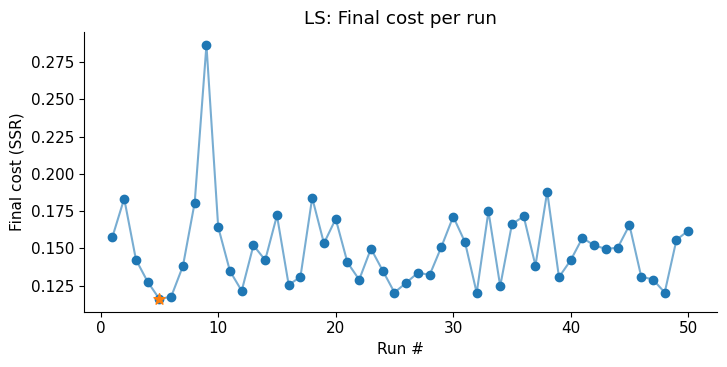

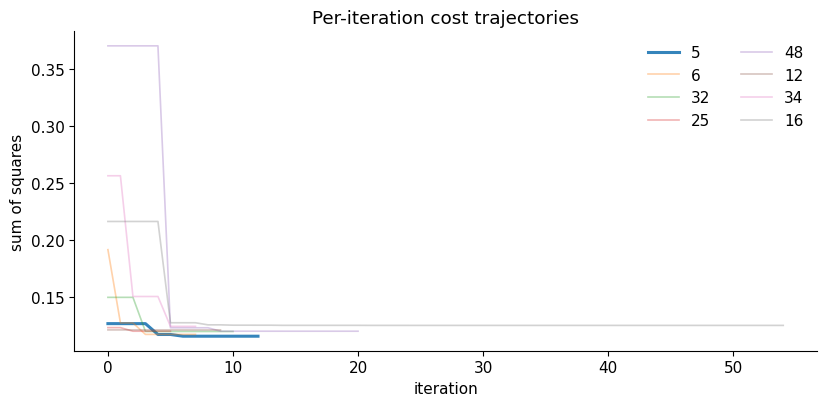

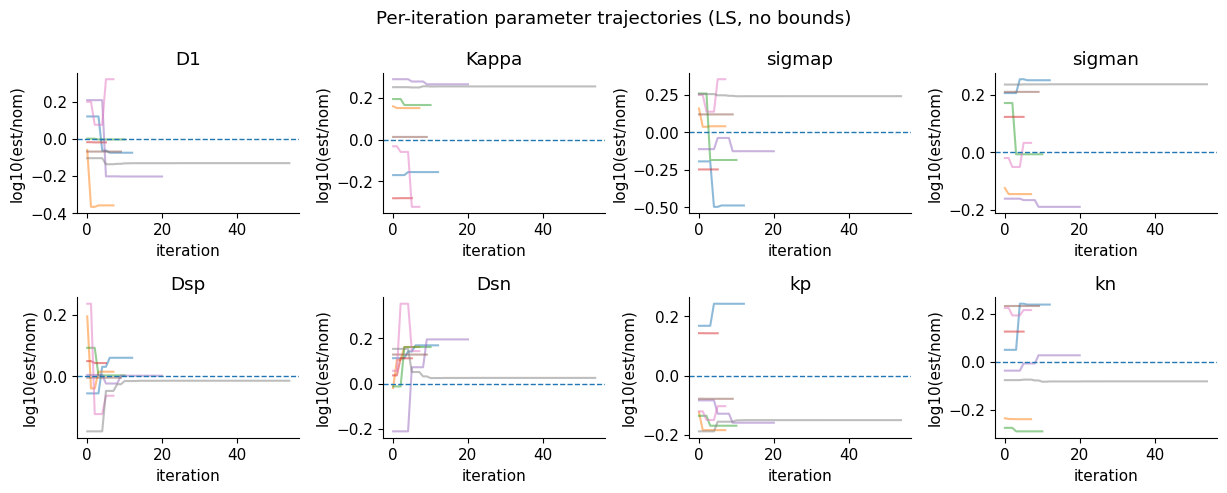

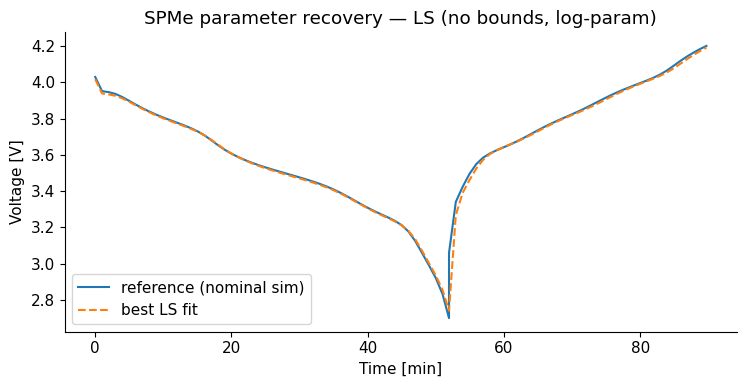


Best-fit vs nominal (relative errors):
  D1     : est=6.07727e-10, nominal=7.2296e-10, rel_err=1.594e-01
  Kappa  : est=0.753395, nominal=1.0794, rel_err=3.020e-01
  sigmap : est=0.0660794, nominal=0.2029, rel_err=6.743e-01
  sigman : est=267.607, nominal=150.5, rel_err=7.781e-01
  Dsp    : est=5.97586e-15, nominal=5.2e-15, rel_err=1.492e-01
  Dsn    : est=5.86695e-14, nominal=3.975e-14, rel_err=4.760e-01
  kp     : est=1.50316e-11, nominal=8.6225e-12, rel_err=7.433e-01
  kn     : est=1.03405e-12, nominal=5.9673e-13, rel_err=7.329e-01
[LS] ||residual||_2 = 0.340545, status: 3


In [12]:
"""
SPMe Parameter Identification — Minimal LS (no bounds; log-param)
-----------------------------------------------------------------
What this script does (end-to-end):
  1) Builds a PyBaMM SPMe simulation with a simple CC (discharge→charge) experiment.
  2) Generates a synthetic "measured" voltage trace using nominal parameters (truth).
  3) Runs multi-start *unconstrained* least-squares in log-space:
       P_i = P_i_nom * exp(z_i),  z_i ∈ ℝ  (no hard bounds)
  4) Prints a compact run summary and sanity-checks initial guesses.
  5) Plots: (a) final cost per run, (b) per-iteration cost paths (best K),
     (c) per-iteration parameter trajectories (grid), (d) best-fit overlay.

Key ideas:
  • No BOUNDS_PCT or make_bounds_from_template. No unit-cube. No hard walls.
  • Stable scaling: z ~ O(1), LM behaves well. Positivity ensured by exp().

To use *real* measurements:
  • Replace the synthetic (t_meas, V_meas) with your arrays.
  • Keep the same run_least_squares(...) call (no lo/hi needed).

Dependencies:
  pip install pybamm scipy numpy matplotlib
"""
from __future__ import annotations
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
import pybamm

# -----------------------------
# 0) Plotting defaults
# -----------------------------
plt.rcParams.update({
    "figure.figsize": (7.6, 4.4),
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# --------------------------------------
# 1) Parameters (nominal truth) & keys
# --------------------------------------
# Variables to estimate (kept small & focused)
vary_keys = [
    "D1", "Kappa", "sigmap", "sigman", "Dsp", "Dsn", "kp", "kn"
]

params_nominal = dict(
    # Geometry
    Ln=85.2e-6, Ls=12e-6, Lp=75.6e-6,
    A=0.11,

    # Mesh resolution (not strictly used below; var_pts set in run_spme)
    Nx=80, Nr=20,

    # Porosities
    eps_e={"n": 0.25, "s": 0.47, "p": 0.335},

    # Transport & kinetics (our targets to estimate)
    D1=7.2296e-10,
    Kappa=1.0794,
    sigmap=0.2029,
    sigman=150.5,
    Dsp=5.2e-15,
    Dsn=3.975e-14,
    kp=8.6225e-12,
    kn=5.9673e-13,

    # Particle radii
    Rp_n=5.86e-6, Rp_p=5.22e-6,

    # Concentration caps & ICs (via stoich)
    csmax_n=29583.0, csmax_p=51765.0,
    tplus=0.363,
    theta_n0=0.90, theta_p0=0.27,

    # Experiment
    n_cycles=1,
    I_cc=5.0, Vmin=2.7, Vmax=4.2, dt=0.05,
)

# --------------------------------------
# 2) PyBaMM mapping & simulation helpers
# --------------------------------------
def build_params_from_dict(d: dict) -> pybamm.ParameterValues:
    base = pybamm.ParameterValues("Chen2020")
    c_n0 = d["theta_n0"] * d["csmax_n"]
    c_p0 = d["theta_p0"] * d["csmax_p"]
    base.update({
        # geometry & area
        "Negative electrode thickness [m]": d["Ln"],
        "Separator thickness [m]": d["Ls"],
        "Positive electrode thickness [m]": d["Lp"],
        "Electrode area [m2]": d["A"],
        # porosities
        "Negative electrode porosity": d["eps_e"]["n"],
        "Separator porosity": d["eps_e"]["s"],
        "Positive electrode porosity": d["eps_e"]["p"],
        # electrolyte transport (assume constant here)
        "Electrolyte diffusivity [m2.s-1]": d["D1"],
        "Electrolyte conductivity [S.m-1] (ref)": d["Kappa"],
        "Cation transference number": d["tplus"],
        # solid transport
        "Negative electrode diffusivity [m2.s-1]": d["Dsn"],
        "Positive electrode diffusivity [m2.s-1]": d["Dsp"],
        # electronic conductivities
        "Negative electrode conductivity [S.m-1]": d["sigman"],
        "Positive electrode conductivity [S.m-1]": d["sigmap"],
        # particle radii
        "Negative particle radius [m]": d["Rp_n"],
        "Positive particle radius [m]": d["Rp_p"],
        # concentrations & ICs
        "Maximum concentration in negative electrode [mol.m-3]": d["csmax_n"],
        "Maximum concentration in positive electrode [mol.m-3]": d["csmax_p"],
        "Initial concentration in negative electrode [mol.m-3]": c_n0,
        "Initial concentration in positive electrode [mol.m-3]": c_p0,
        # kinetics
        "Negative electrode reaction rate constant [m2.5 mol-0.5 s-1]": d["kn"],
        "Positive electrode reaction rate constant [m2.5 mol-0.5 s-1]": d["kp"],
        # isothermal
        "Ambient temperature [K]": 298.15,
        "Reference temperature [K]": 298.15,
    }, check_already_exists=False)
    return base

def make_experiment(d: dict) -> pybamm.Experiment:
    I, Vmin, Vmax, n_cycles = float(d["I_cc"]), d["Vmin"], d["Vmax"], int(d.get("n_cycles", 1))
    steps = [f"Discharge at {I} A until {Vmin} V", f"Charge at {I} A until {Vmax} V"] * n_cycles
    return pybamm.Experiment(steps)

def run_spme(d: dict):
    model = pybamm.lithium_ion.SPMe(options={
        "surface form": "algebraic", "thermal": "isothermal",
        "SEI": "none", "lithium plating": "none",
    })
    param = build_params_from_dict(d)

    var_pts = {"x_n": 20, "x_s": 15, "x_p": 20, "r_n": 30, "r_p": 30}
    experiment = make_experiment(d)

    dt = float(d.get("dt", 0.05))
    try:
        solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-6, dt_max=dt)
    except Exception:
        solver = pybamm.ScipySolver(atol=1e-6, rtol=1e-6, mode="safe")

    sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment,
                             var_pts=var_pts, solver=solver)
    sol = sim.solve()
    return sol, sim

def simulate_voltage(pd: dict):
    sol, _ = run_spme(pd)
    t = sol["Time [s]"].entries
    V = sol["Terminal voltage [V]"].entries
    I = sol["Current [A]"].entries
    return t, V, I

def align_to(t_src, y_src, t_dst, fill_value="extrapolate"):
    f = interp1d(t_src, y_src, kind="linear", bounds_error=False, fill_value=fill_value)
    return f(t_dst)

# -------------------------------------------------
# 3) Log-parameterization (unconstrained) + residuals
# -------------------------------------------------
def z_to_physical(template: dict, z: np.ndarray, keys=vary_keys) -> dict:
    """
    Map unconstrained z in R^n to physical params by P = P_nom * exp(z).
    No hard bounds. z=0 → nominal; z≈±0.69 ~ 0.5x–2x; but optimizer can roam.
    """
    d = dict(template)
    for k, zi in zip(keys, z):
        d[k] = float(template[k] * math.exp(zi))
    return d

def residuals_V(z: np.ndarray, V_meas: np.ndarray, t_meas: np.ndarray,
                template: dict, keys=vary_keys, penalty: float = 1e3) -> np.ndarray:
    try:
        pd = z_to_physical(template, z, keys)
        t_sim, V_sim, _ = simulate_voltage(pd)
    except Exception:
        # keep optimization alive if PyBaMM fails at some crazy z
        return np.full_like(V_meas, penalty, float)

    if (t_sim.shape != t_meas.shape) or (not np.allclose(t_sim, t_meas)):
        V_sim = align_to(t_sim, V_sim, t_meas)
    return (V_meas - V_sim).astype(float)

# -------------------------------------------------
# 4) Least-squares (multi-start) + logging (unconstrained LM)
# -------------------------------------------------
def run_least_squares(t_meas: np.ndarray, V_meas: np.ndarray,
                      template: dict, keys=vary_keys,
                      n_starts: int = 8, seed: int | None = 0,
                      max_nfev: int = 200, tol: float = 1e-9,
                      record_path: bool = True):
    rng = np.random.default_rng(seed)
    n = len(keys)
    best = None
    runs: list[dict] = []

    for i in range(1, n_starts + 1):
        # Unbounded starts in log-space (≈0.5x–2x around nominal)
        z0 = rng.uniform(-0.7, 0.7, size=n)
        z_path: list[np.ndarray] = []
        cost_path: list[float] = []

        def fun_wrapped(z):
            r = residuals_V(z, V_meas, t_meas, template, keys)
            if record_path:
                c = float(np.dot(r, r))
                if (not cost_path) or c < cost_path[-1] - 1e-12 * max(1.0, abs(cost_path[-1])):
                    z_path.append(np.array(z, float))
                    cost_path.append(c)
            return r

        # Levenberg–Marquardt = unconstrained (requires m >= n, which holds here)
        res = least_squares(fun_wrapped, z0, method="lm",
                            ftol=tol, xtol=tol, gtol=tol, max_nfev=max_nfev)
        zhat = res.x
        est_params = z_to_physical(template, zhat, keys)
        runs.append({
            "start": i,
            "x0": z0,              # store as "x0" for reuse in plotting helpers
            "xhat": zhat,
            "residual_norm_2": float(np.linalg.norm(res.fun)),
            "status": int(res.status),
            "est_params": {k: float(est_params[k]) for k in keys},
            "x_path": z_path,      # path is a list of z vectors
            "cost_path": cost_path,
        })

        print(f"[start {i}/{n_starts}] ||res||_2={np.linalg.norm(res.fun):.6g} status={res.status}")
        if (best is None) or (np.linalg.norm(res.fun) < np.linalg.norm(best.fun)):
            best = res

    best_est = z_to_physical(template, best.x, keys)
    return best_est, best, runs

# -------------------------------------------------
# 5) Summaries & Plots (unchanged API for convenience)
# -------------------------------------------------
def print_runs_summary(runs, keys=vary_keys):
    print("\n=== Multi-start summary ===")
    header = ["start", "||res||_2"] + [f"est_{k}" for k in keys]
    print(" | ".join(f"{h:>14s}" for h in header))
    for r in runs:
        row = [f"{r['start']:>14d}", f"{r['residual_norm_2']:>14.6g}"]
        row += [f"{r['est_params'][k]:>14.6g}" for k in keys]
        print(" | ".join(row))

def check_initial_guesses(runs):
    Z0 = np.stack([r["x0"] for r in runs])
    print("z0 per-dimension min:", np.min(Z0, axis=0))
    print("z0 per-dimension max:", np.max(Z0, axis=0))

def _final_cost(r):
    return float(r.get("cost_path", [r["residual_norm_2"]**2])[-1])

def top_k_runs_by_cost(runs, k=8):
    return sorted(runs, key=_final_cost)[:k]

def plot_run_vs_final_cost(runs, logy=False, title="LS: Final cost per run"):
    xs = [r["start"] for r in runs]
    ys = [_final_cost(r) for r in runs]
    order = np.argsort(xs)
    xs, ys = np.array(xs)[order], np.array(ys)[order]
    plt.figure(figsize=(7.4, 3.8))
    plt.scatter(xs, ys)
    plt.plot(xs, ys, alpha=0.6)
    if logy: plt.yscale("log")
    plt.xlabel("Run #"); plt.ylabel("Final cost (SSR)"); plt.title(title)
    i_best = int(np.argmin(ys))
    plt.scatter([xs[i_best]], [ys[i_best]], s=70, marker="*", zorder=5)
    plt.tight_layout(); plt.show()

def plot_cost_paths(runs, logy=False, legend_loc="upper right"):
    plt.figure(figsize=(8.4, 4.2))
    # best-run highlighting
    best_idx = int(np.argmin([_final_cost(r) for r in runs]))
    for i, r in enumerate(runs):
        cp = r.get("cost_path", [])
        if not cp: continue
        it = np.arange(len(cp))
        kw = dict(alpha=0.9, linewidth=2.2) if i == best_idx else dict(alpha=0.35, linewidth=1.2)
        plt.plot(it, cp, label=str(r.get("start", i+1)), **kw)
    if logy: plt.yscale("log")
    plt.xlabel("iteration"); plt.ylabel("sum of squares")
    plt.title("Per-iteration cost trajectories")
    plt.legend(loc=legend_loc, frameon=False, ncol=2)
    plt.tight_layout(); plt.show()

def plot_param_trajectories_grid(runs, keys=vary_keys, template=None, scale="logrel"):
    n_params = len(keys)
    ncols = 4
    nrows = math.ceil(n_params / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.1*ncols, 2.5*nrows), sharex=False)
    axes = np.atleast_1d(axes).ravel()

    def z_to_phys(z):
        return z_to_physical(template, z, keys)

    for pi, k in enumerate(keys):
        ax = axes[pi]
        for r in runs:
            Z = r.get("x_path", [])
            if not Z: continue
            vals = [z_to_phys(zk)[k] for zk in Z]
            y = np.array(vals, float)
            if scale == "logrel" and template is not None:
                nom = template[k] if template[k] != 0 else 1.0
                y = np.log10(np.clip(y / nom, 1e-300, 1e300))
                ax.set_ylabel("log10(est/nom)")
            ax.plot(np.arange(len(y)), y, alpha=0.5)
        ax.set_title(k); ax.set_xlabel("iteration")
        if scale == "logrel":
            ax.axhline(0.0, ls="--", lw=1.0)

    for j in range(n_params, nrows*ncols):
        fig.delaxes(axes[j])
    fig.suptitle("Per-iteration parameter trajectories (LS, no bounds)")
    fig.tight_layout(); plt.show()

# ---------------------------------
# 6) Demo main — synthetic data
# ---------------------------------
if __name__ == "__main__":
    # Synthetic measurement (clean)
    t_meas, V_meas, _ = simulate_voltage(params_nominal)

    # Fit (unconstrained LS in log-space)
    best_params, res_best, runs = run_least_squares(
        t_meas=t_meas, V_meas=V_meas,
        template=params_nominal, keys=vary_keys,
        n_starts=50, seed=None, max_nfev=200, tol=1e-9,
    )

    # Summaries
    print_runs_summary(runs, keys=vary_keys)
    check_initial_guesses(runs)

    # Plots (final-cost per run, then top-K cost paths)
    plot_run_vs_final_cost(runs, logy=False)
    bestK = top_k_runs_by_cost(runs, k=min(8, len(runs)))
    plot_cost_paths(bestK, logy=False)

    # Parameter trajectories grid (using best K for clarity)
    plot_param_trajectories_grid(bestK, keys=vary_keys, template=params_nominal, scale="logrel")

    # Best-fit overlay vs reference
    from numpy import allclose
    t_fit, V_fit, _ = simulate_voltage(best_params)
    if (t_fit.shape != t_meas.shape) or (not allclose(t_fit, t_meas)):
        V_fit = align_to(t_fit, V_fit, t_meas)

    plt.figure(figsize=(7.6, 4.0))
    plt.plot(t_meas/60, V_meas, label="reference (nominal sim)")
    plt.plot(t_meas/60, V_fit, "--", label="best LS fit")
    plt.xlabel("Time [min]"); plt.ylabel("Voltage [V]")
    plt.title("SPMe parameter recovery — LS (no bounds, log-param)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Print best-fit vs nominal
    print("\nBest-fit vs nominal (relative errors):")
    for k in vary_keys:
        nom = params_nominal[k]
        rel = abs(best_params[k] - nom) / (abs(nom) if nom != 0 else 1.0)
        print(f"  {k:7s}: est={best_params[k]:.6g}, nominal={nom:.6g}, rel_err={rel:.3e}")
    print(f"[LS] ||residual||_2 = {np.linalg.norm(res_best.fun):.6g}, status: {res_best.status}")


In [13]:
import IPython

# This will tell Jupyter to save the notebook in place
IPython.display.display(IPython.display.Javascript('IPython.notebook.save_checkpoint();'))


<IPython.core.display.Javascript object>